# Time Series Analysis on PJME Hourly Energy Consumption

Welcome to this in-depth notebook where we embark on an exploration of time series analysis, focusing specifically on forecasting hourly energy consumption. We leverage the **PJME_hourly** dataset provided by PJM, a regional transmission organization in the United States. This dataset features detailed records of energy consumption across the eastern section of the U.S. from January 2002 to August 2018, offering a rich canvas to analyze and predict energy use patterns.

## Dataset Overview
The **PJME_hourly** dataset offers a comprehensive view of historical energy consumption data, meticulously recorded on an hourly basis over more than 16 years. This extensive timeframe allows for an in-depth examination of consumption trends, including seasonal variations and long-term shifts in energy demand. Analyzing this dataset can provide invaluable insights into energy usage dynamics, essential for effective energy management and distribution planning.

## Objective
Our goal is to harness advanced machine learning techniques for time series forecasting, aiming to predict future energy consumption with high accuracy. By analyzing the historical data in the PJME_hourly dataset, we seek to:

- Uncover and visualize energy consumption trends and patterns.
- Identify seasonality, trends, and anomalies in energy consumption.
- Compare the forecasting capabilities of **XGBoost** and **Facebook's Prophet**—two of the leading methods in time series forecasting—to determine their effectiveness and accuracy in predicting energy consumption.

## Methodology
Our analysis will proceed through several key stages:

1. **Data Preprocessing**: Preparing the dataset for analysis by cleaning and addressing any inconsistencies or missing values.
2. **Exploratory Data Analysis (EDA)**: Conducting a thorough examination of the dataset to identify trends, patterns, and insights.
3. **Feature Engineering**: Developing features that can enhance the predictive performance of our models.
4. **Model Building**: Implementing and tuning two forecasting models—XGBoost and Facebook's Prophet—to predict hourly energy consumption.
5. **Evaluation and Comparison**: Evaluating the performance of both models using suitable metrics and comparing their forecasting accuracy on unseen data.

## Tools and Libraries
This analysis will utilize a range of Python libraries, including:

- `pandas` and `numpy` for data manipulation and numerical computations.
- `matplotlib` and `seaborn` for visualizing data trends and patterns.
- `xgboost` for constructing the gradient boosting model.
- `fbprophet` for implementing Facebook's Prophet model.
- `sklearn` for additional modeling tools and performance metrics.

## Conclusion
By comparing XGBoost and Facebook's Prophet, this notebook aims to identify the most effective method for forecasting hourly energy consumption. Our analysis will not only shed light on the predictive power of these models but also contribute valuable insights for energy management and optimization strategies. Join us as we delve into the data and uncover the dynamics of energy consumption in the eastern United States from 2002 to 2018.

#### Let's Get Started!

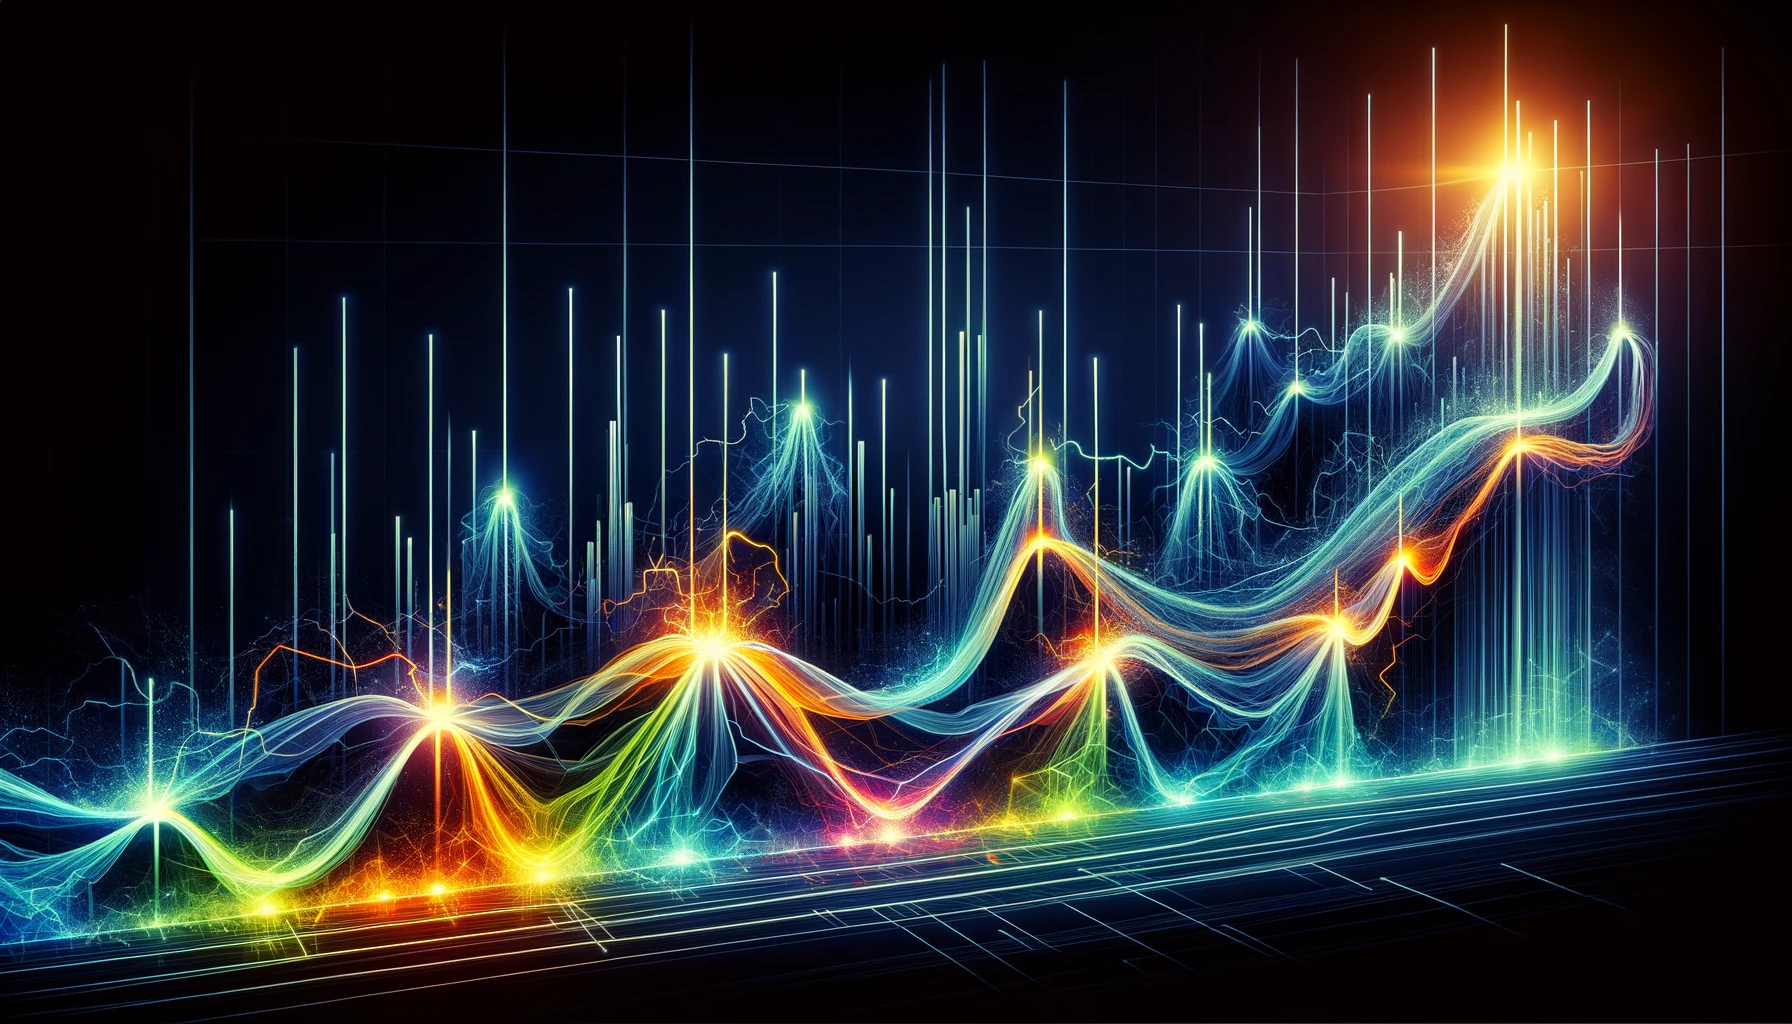

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import xgboost as xgb
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Importing dataset
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')

In [3]:
# Preprocessing data - covnverting date to datetime format, setting as index
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
df = df.sort_index()

In [4]:
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [5]:
df.shape

(145366, 1)

In [6]:
df.isnull().sum()

PJME_MW    0
dtype: int64

No missing values, we can move on to eda

# EDA
Taking quick looks at the data in different time intervals to get a general understanding of any patterns or consistencies. Later when we create our features we will get a deeper understanding by averaging consumption over different time periods.

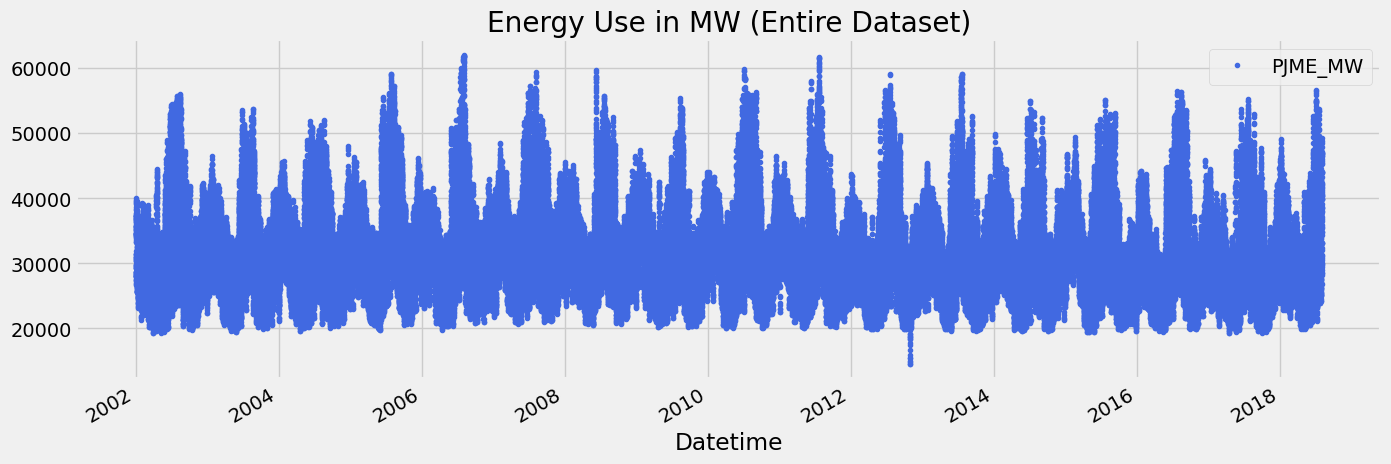

In [7]:
plt.style.use('fivethirtyeight')

# Plotting the entire dataset
df.plot(style='.',
        figsize=(15, 5),
        color='royalblue',
        title='Energy Use in MW (Entire Dataset)')
plt.show()

There appears to be strong seasonality with peaks halfway through each year

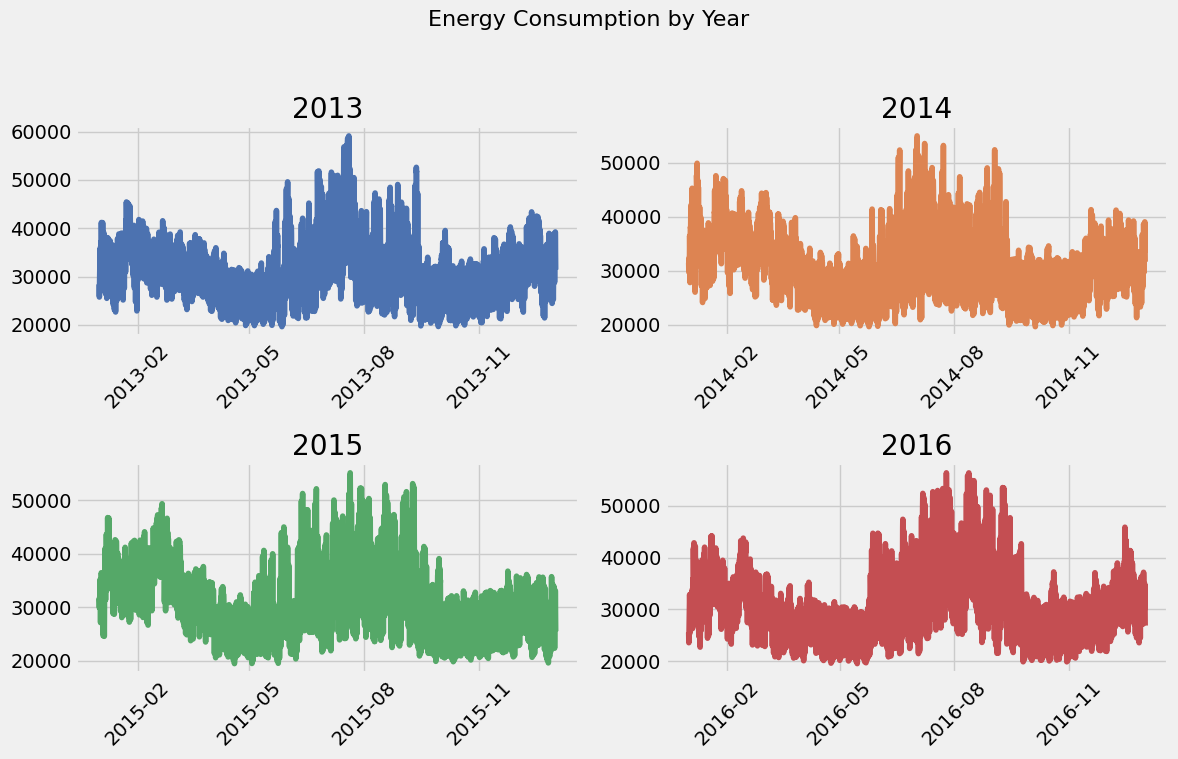

In [8]:
# Plotting 4 graphs, one for each year of energy consumption 2013-2016

year_one = df.loc[(df.index >= '2013-01-01 01:00:00') & (df.index <= '2014-01-01 01:00:00')]
year_two = df.loc[(df.index >= '2014-01-01 01:00:00') & (df.index <= '2015-01-01 01:00:00')]
year_three = df.loc[(df.index >= '2015-01-01 01:00:00') & (df.index <= '2016-01-01 01:00:00')]
year_four = df.loc[(df.index >= '2016-01-01 01:00:00') & (df.index <= '2017-01-01 01:00:00')]
years = [year_one, year_two, year_three, year_four]
year_labels = ['2013', '2014', '2015', '2016']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption by Year', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('deep', 4)

for i, year in enumerate(years):
    axes[i].plot(year.index, year['PJME_MW'], color=colors[i])
    axes[i].set_title(year_labels[i])
    axes[i].set
    
    axes[i].xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Setting x axis tick marks/intervals
    
    axes[i].tick_params(axis='x', rotation=45)  # rotate x-axis labels for better readability

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

Years maintain the same general pattern. Energy consumption appears to increase in the summer and winter / decrease in the spring and fall.

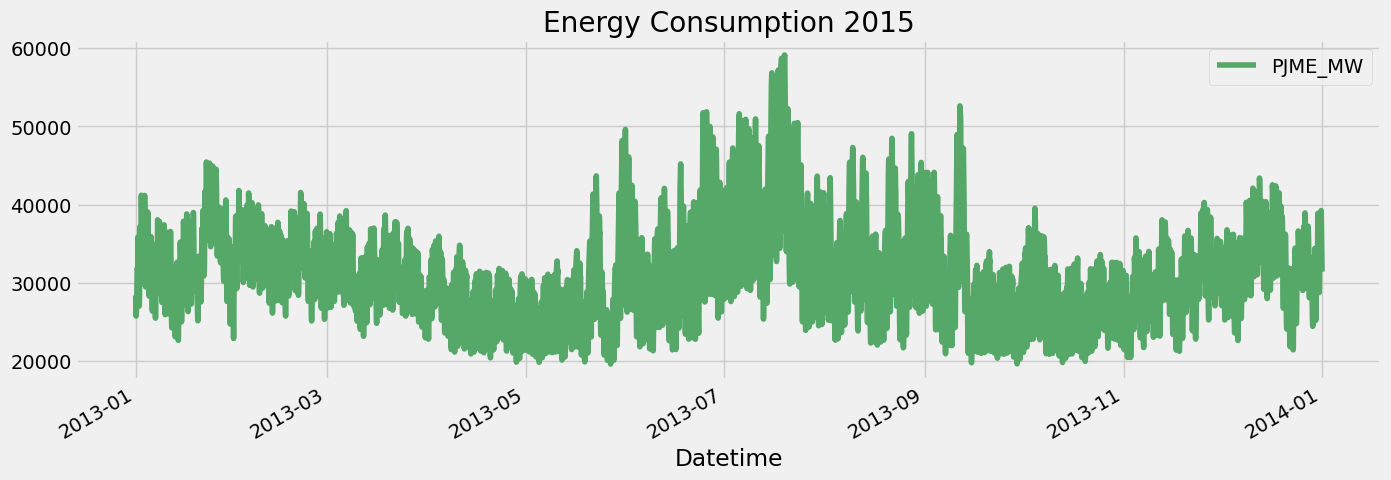

In [9]:
# Looking closer at a year
year_one.plot(figsize=(15, 5),
              title="Energy Consumption 2015",
              color=colors[2])
plt.show()

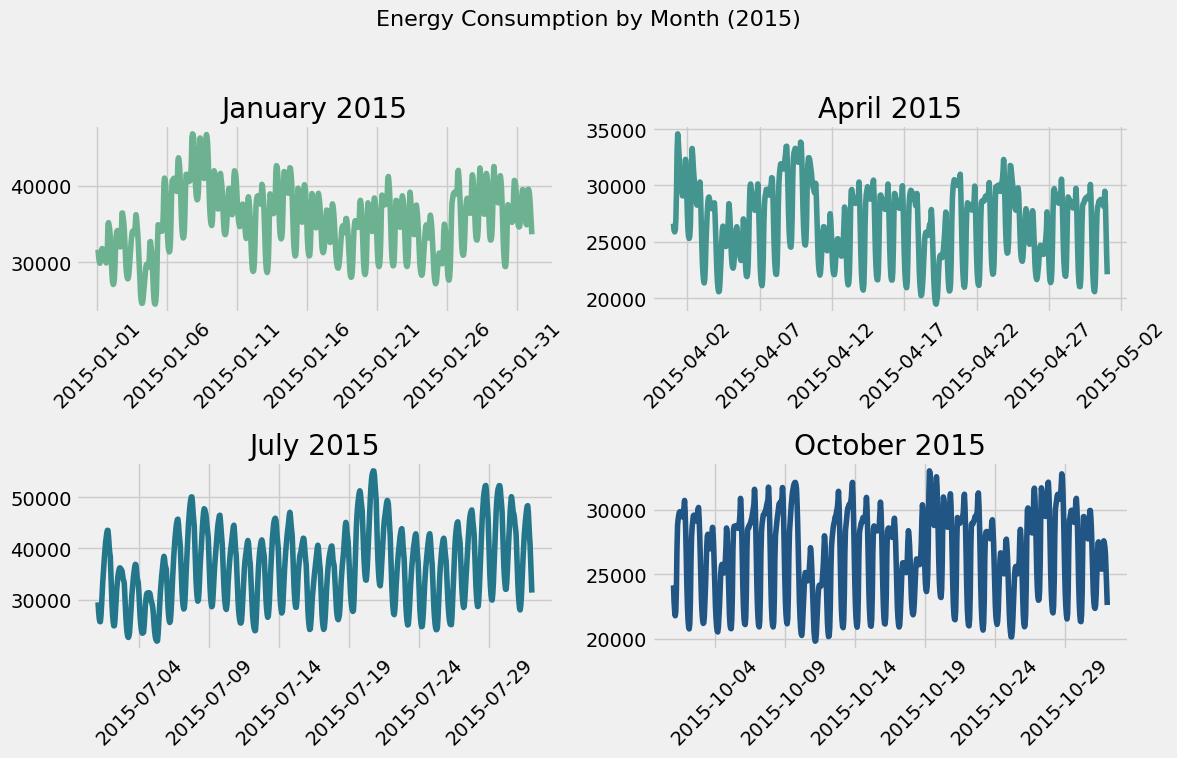

In [10]:
# Plotting 4 graphs, one for each month of energy consumption for each season 
# We'll plot January, April, July, and October for Winter, Spring, Summer, Fall Respectively 
month_one = df.loc[(df.index >= '2015-01-01 01:00:00') & (df.index <= '2015-02-01 01:00:00')]
month_two = df.loc[(df.index >= '2015-04-01 01:00:00') & (df.index <= '2015-05-01 01:00:00')]
month_three = df.loc[(df.index >= '2015-07-01 01:00:00') & (df.index <= '2015-08-01 01:00:00')]
month_four = df.loc[(df.index >= '2015-10-01 01:00:00') & (df.index <= '2015-11-01 01:00:00')]
months = [month_one, month_two, month_three, month_four]
month_labels = ['January 2015', 'April 2015', 'July 2015', 'October 2015']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption by Month (2015)', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('crest', 4)

for i, month in enumerate(months):
    axes[i].plot(month.index, month['PJME_MW'], color = colors[i])
    axes[i].set_title(month_labels[i])
    
    axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=5))  # Setting x axis tick marks/intervals
    
    axes[i].tick_params(axis='x', rotation=45)  # rotate x-axis labels
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

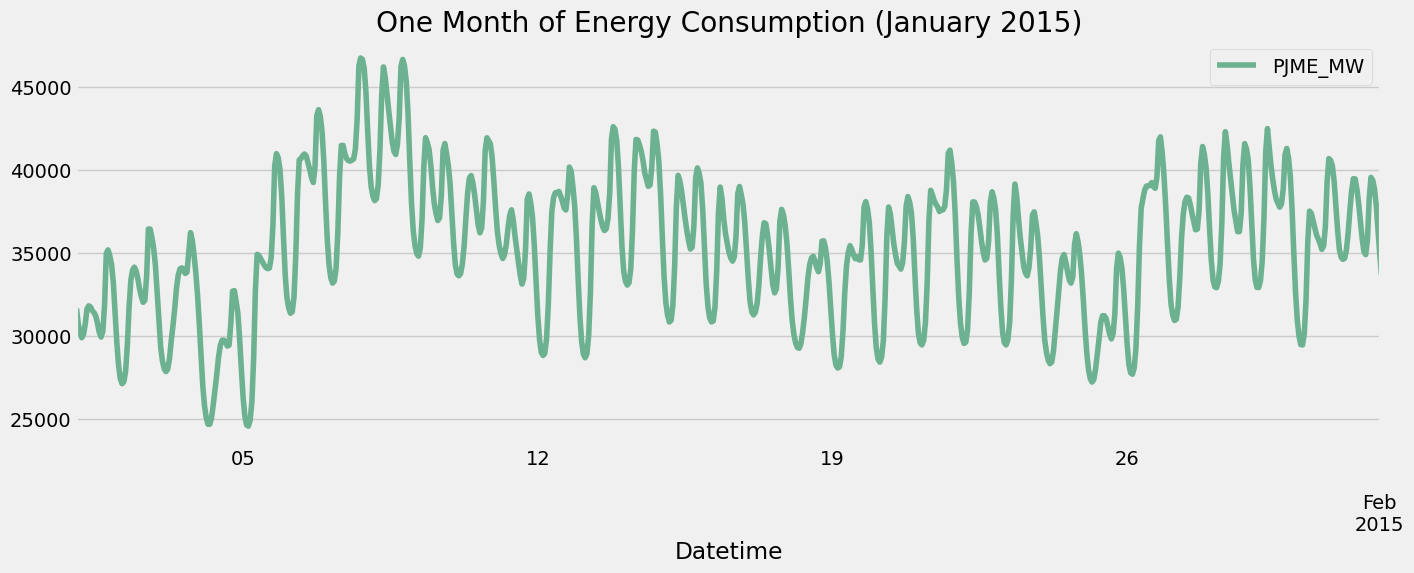

In [11]:
# Taking a closer look at one month
month_one.plot(figsize=(15, 5),
              title="One Month of Energy Consumption (January 2015)",
              color=colors[0])
plt.show()

At a glance, months do not appear to resemble one another in overall structure. Energy consumption appears to align more on a daily/weekly basis, we will dig deeper.

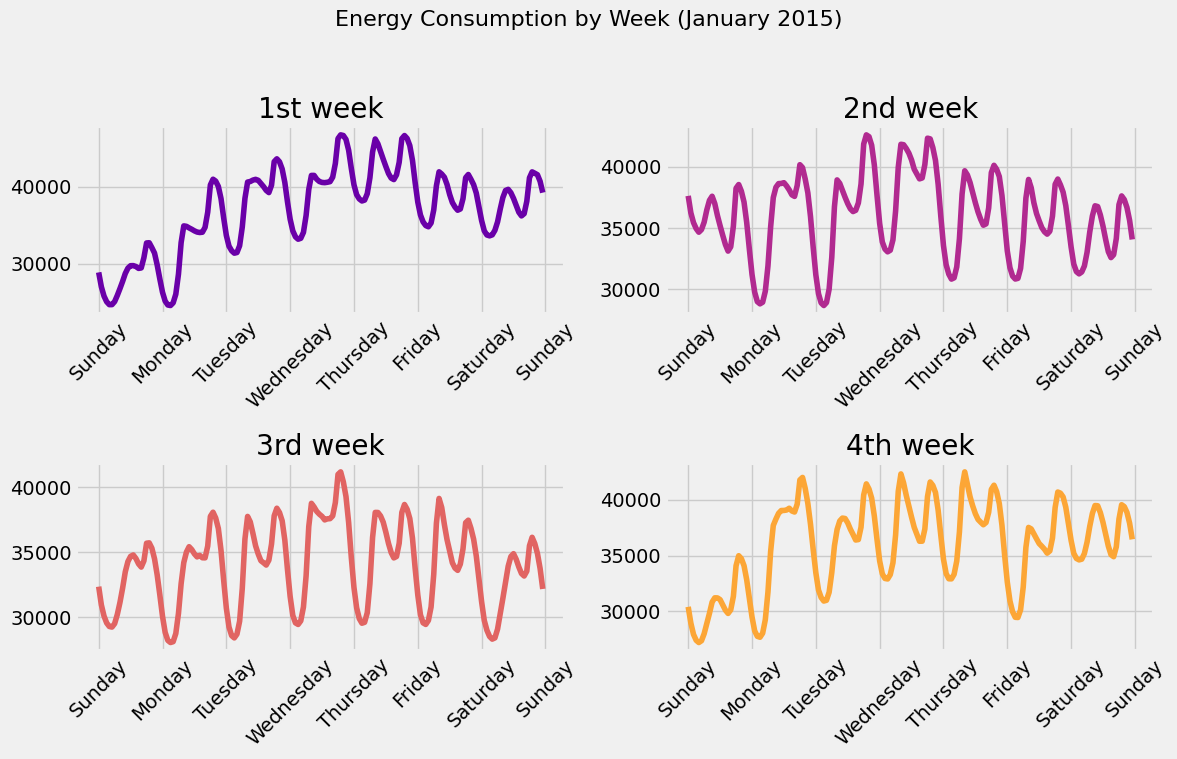

In [12]:
# Plotting 4 graphs, one for each week of energy consumption January 2015
# Starting on January 4th as its a Sunday
# Plotting Sunday - Saturday for each week
week_one = df.loc[(df.index >= '2015-01-04 00:00:00') & (df.index < '2015-01-11 00:00:00')]
week_two = df.loc[(df.index >= '2015-01-11 00:00:00') & (df.index < '2015-01-18 00:00:00')]
week_three = df.loc[(df.index >= '2015-01-18 00:00:00') & (df.index < '2015-01-25 00:00:00')]
week_four = df.loc[(df.index >= '2015-01-25 00:00:00') & (df.index < '2015-02-1 00:00:00')]

weeks = [week_one, week_two, week_three, week_four]
week_labels = ['1st week', '2nd week', '3rd week', '4th week']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption by Week (January 2015)', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('plasma', 4)

for i, week in enumerate(weeks):
    axes[i].plot(week.index, week['PJME_MW'], color = colors[i])
    axes[i].set_title(week_labels[i])
    
    axes[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Setting x axis tick marks/intervals
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%A')) # Format x axis to say day names
        
    axes[i].tick_params(axis='x', rotation=45)  # rotate x-axis labels
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

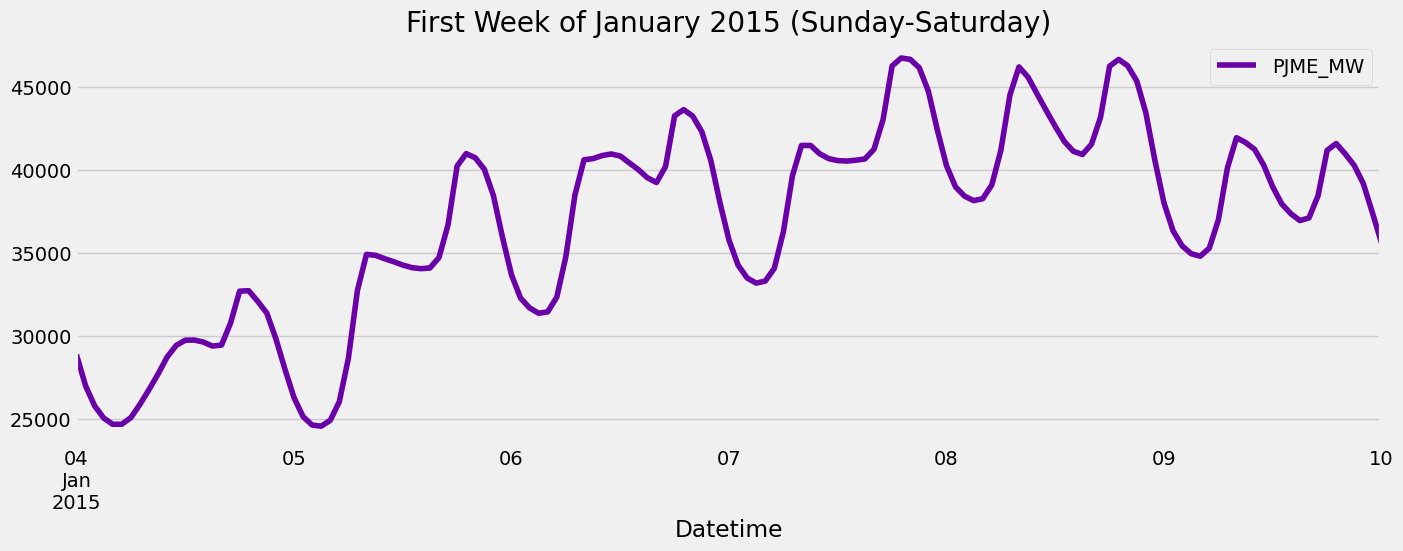

In [13]:
# Looking closer at the first week in january
one_week = df.loc[(df.index >= '2015-01-04') & (df.index <= '2015-01-10')]

# Plotting one week of data
ax = one_week.plot(figsize=(15, 5),
              title="First Week of January 2015 (Sunday-Saturday)",
              color=colors[0])


plt.show()

Energy usage appears to increase throughout the week from Sunday-Friday, then dropping off on Saturday. Days appears to retain the same pattern regardless of the day of the week.

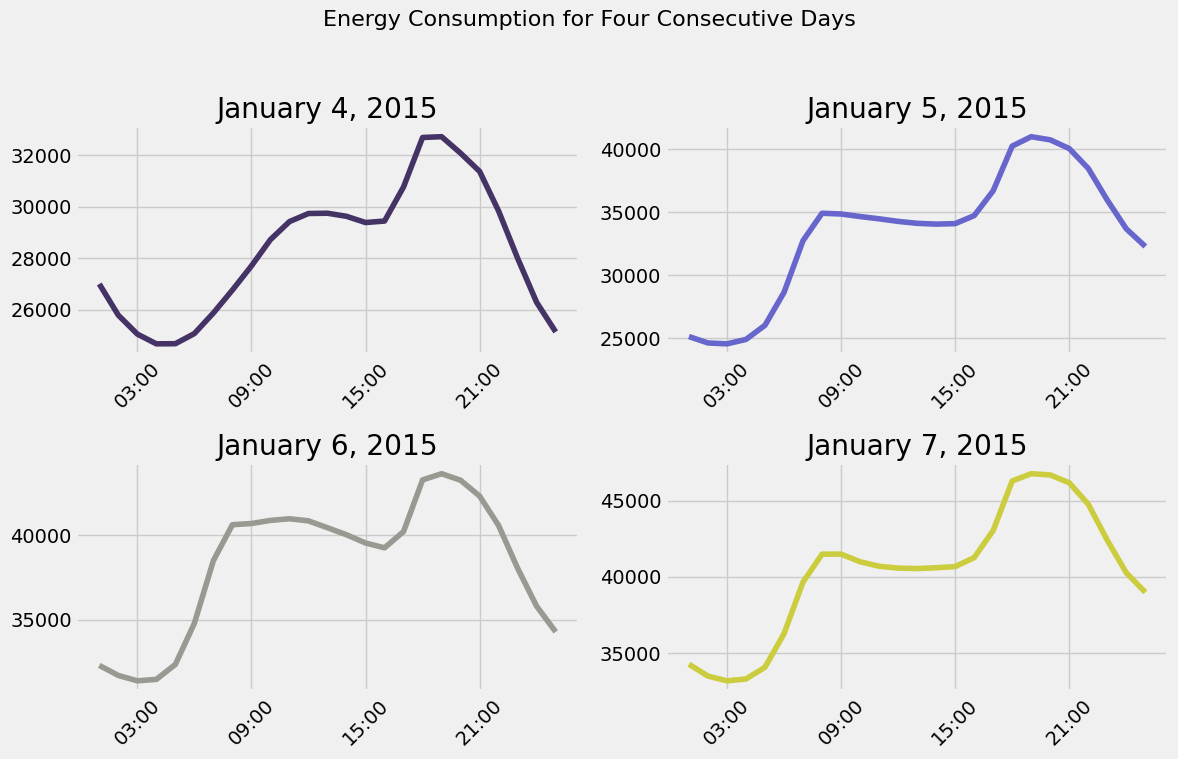

In [14]:
# Pulling out one day of data
day_one = df.loc[(df.index >= '2015-01-04 01:00:00') & (df.index <= '2015-01-05 01:00:00')]
day_two = df.loc[(df.index >= '2015-01-05 01:00:00') & (df.index <= '2015-01-06 01:00:00')]
day_three = df.loc[(df.index >= '2015-01-06 01:00:00') & (df.index <= '2015-01-07 01:00:00')]
day_four = df.loc[(df.index >= '2015-01-07 01:00:00') & (df.index <= '2015-01-08 01:00:00')]
days = [day_one, day_two, day_three, day_four]
day_labels = ['January 4, 2015', 'January 5, 2015', 'January 6, 2015', 'January 7, 2015']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Energy Consumption for Four Consecutive Days', fontsize=16)

axes = axes.flatten()

colors = sns.color_palette('gist_stern', 4)

for i, day in enumerate(days):
    axes[i].plot(day.index, day['PJME_MW'], color=colors[i])
    axes[i].set_title(day_labels[i])
    
    axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=6))  # Setting x axis tick marks/intervals
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Show hours and minutes
    
    
    axes[i].tick_params(axis='x', rotation=45)  # Optionally rotate x-axis labels for better readability

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

While the range of energy consumed for a specific day varies signifigantly, each day largely retains the same general pattern of consumption. It is lowest during the night, hits a local maximum in the morning, and its global maximum towards the evening. This is not particularly surprising, if you were to guess at energy consumption for a day you would probably be pretty close, but is nice to find patterns within our data.

We will investigate further by plotting the averages to make sure the data we've looked at is not solely specific to the random time frames we've chosen. 

# Splitting Data Into Train / Test Sets

In [15]:
# Function to split data at Jan 1 2015 for use later
def split_data(df, split_date='01-01-2015'):
    """
    Split dataframe into a train and a test set
    """
    train = df.loc[df.index < split_date]
    test = df.loc[df.index >= split_date]
    return train, test

train, test = split_data(df)

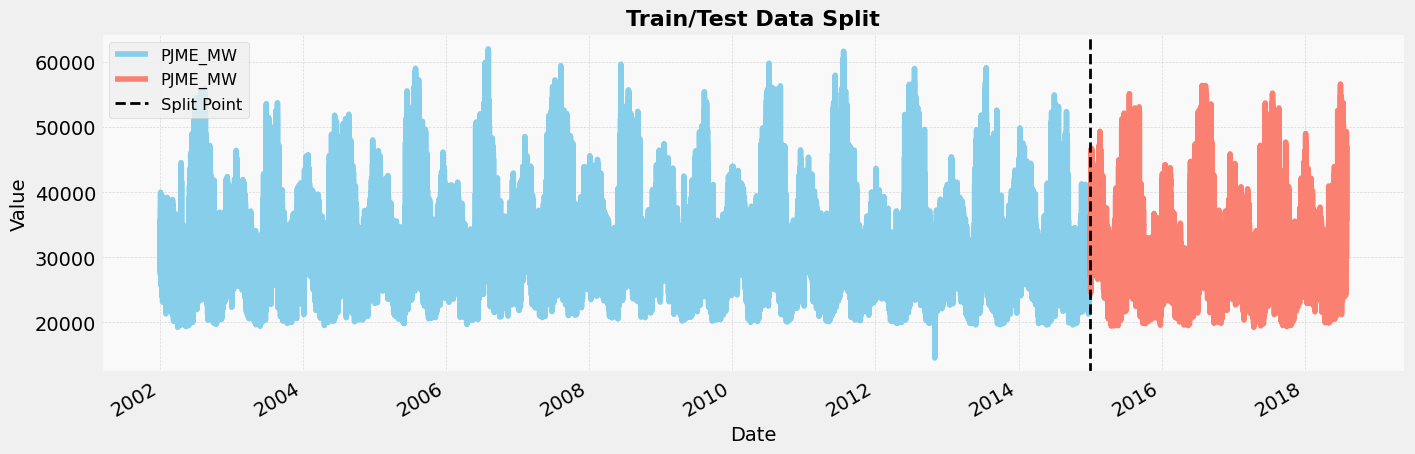

In [16]:
# Visualizing our train/test split
fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, color='skyblue', label='Training Set')
test.plot(ax=ax, color='salmon', label='Test Set')

ax.axvline(pd.to_datetime('01-01-2015'), color='black', ls='--', lw=2, label='Split Point')

# Customization
ax.set_title('Train/Test Data Split', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Value', fontsize=14)
ax.legend(fontsize='small', loc='upper left')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area

plt.show()

# Feature Creation

In [17]:
import holidays

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return add_holidays(df)

def add_holidays(df, country='US'):
    """
    Create binary feature to indicate whether that day is a holiday or not
    """
    df = df.copy()
    
    # Create an instance of the holiday class for the specified country
    holiday_list = holidays.CountryHoliday(country)
    
    # Make a new column with '0' for non-holidays and '1' for holidays
    df['holiday'] = df.index.map(lambda x: x in holiday_list).astype(int)
    
    return df
    
df_original = df.copy()
df = create_features(df)
df = add_holidays(df)

In [18]:
christmas = df.loc[df.index == '2015-12-25']
new_years = df.loc[df.index == '2016-01-01']
random_day = df.loc[df.index == '2016-01-02']
print('christmas',christmas['holiday'])
print('new years',new_years['holiday'])
print('non-holiday',random_day['holiday'])

christmas Datetime
2015-12-25    1
Name: holiday, dtype: int64
new years Datetime
2016-01-01    1
Name: holiday, dtype: int64
non-holiday Datetime
2016-01-02    0
Name: holiday, dtype: int64


## Feature/Target Relationships

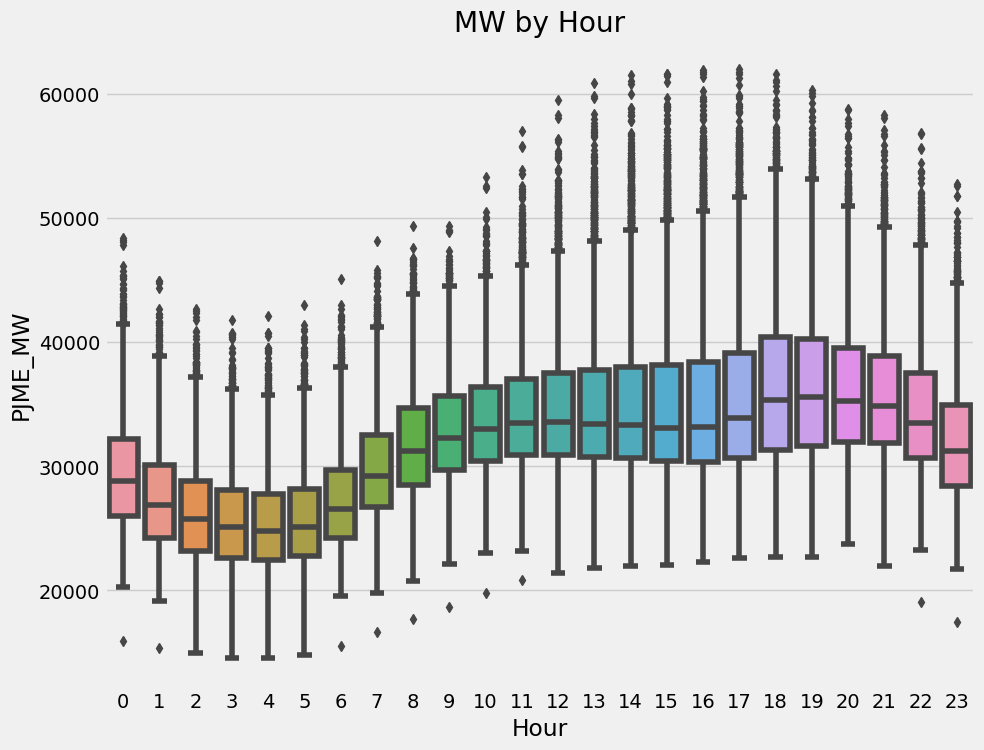

In [19]:
# Distributions of each hour of the day
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
ax.set_xlabel('Hour')
plt.show()

Energy usage peaks at 6 pm and gradually decreases until it reaches its minimum at 4 am. This aligns with what we found looking at our random days. We can assume hour of the day will be a major contributing factor to predicting energy consumption.

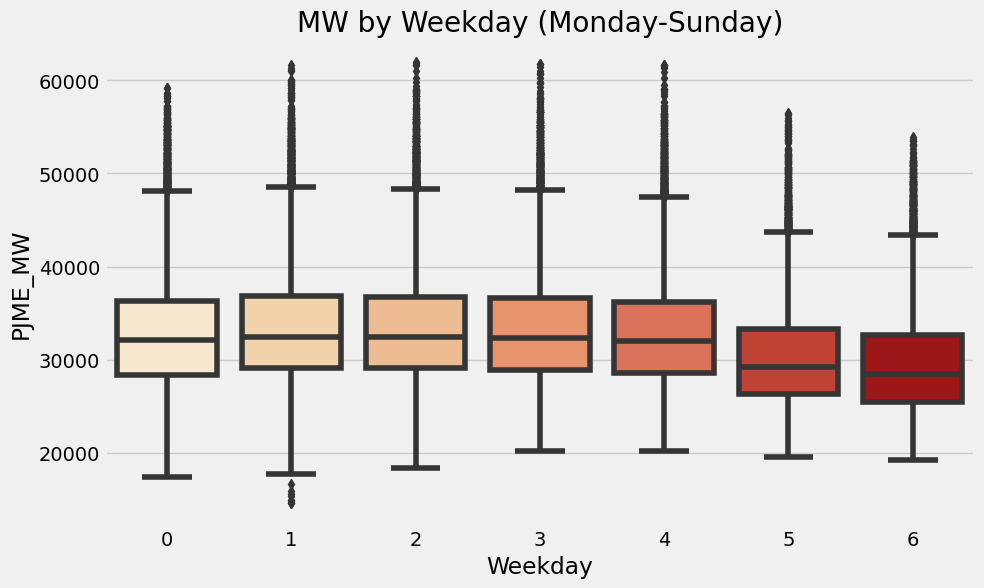

In [20]:
# Distributions of each day of the week
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='dayofweek', y='PJME_MW', palette='OrRd')
ax.set_xlabel('Weekday')
ax.set_title('MW by Weekday (Monday-Sunday)')
plt.show()

Energy consumption is signifigantly lower on the weekends. This could be due to large office buildings being closed which require signifigantly more power to operate than residential homes. This also aligns with what we found in our initial exploration, showing that on weekends, a signifigantly less amount of power is consumed. This may lead to the day of the week feature being an important variable towards predicting consumption.

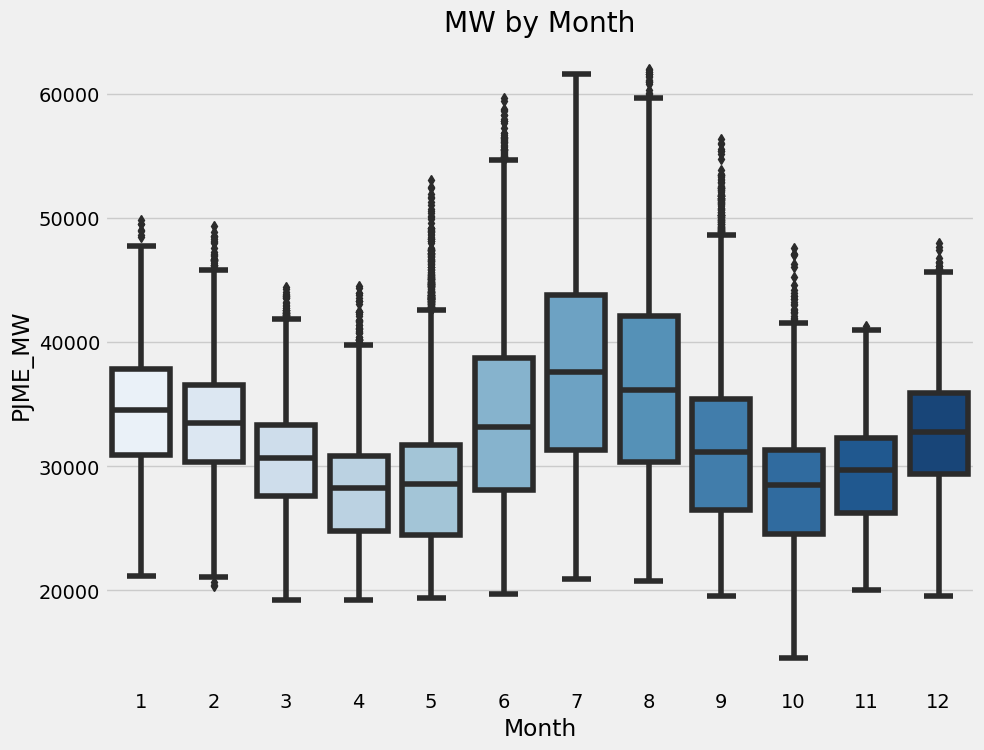

In [21]:
# Distributions of each month
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
ax.set_xlabel('Month')
plt.show()

There is clear seasonality which can likely be attributed to more extreme weather in the peak of winter or summer, causing more energy to be used for heat and A/C respectively. This also aligns with the patterns we saw when plotting years previously. Month of the year may be a major feature aiding to predict consumption. Once we build our XGBoost model, we'll be able to see exactly which features contributed the most to the predicitons of our target variable.

### Prepping our data for XGBoost

In [22]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'holiday', 'weekofyear', 'dayofmonth']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# Using XGBoost to Forecast Energy Consumption

XGBoost is an efficient and scalable machine learning algorithm that employs gradient boosting framework to build sequential trees, aiming to correct the mistakes of previous ones. It combines the predictions from all trees to improve accuracy and incorporates regularization to reduce overfitting. The ensemble approach of XGBoost, using multiple decision trees, allows it to capture complex patterns in data, making it effective for a wide range of predictive modeling tasks.

**Why use it for time series forecasting?**
XGBoost works well for time series forecasting because its ensemble method effectively captures temporal dependencies and nonlinear relationships within the data, while its regularization features help in preventing overfitting to the historical trends, ensuring robust predictions for future observations.

### XGBoost Parameters
**base_score**: This is the initial prediction score of all instances, before any boosting (tree) is performed. It's like an initial guess for the model.

**booster**: This parameter defines the type of model to run at each iteration. It can be gbtree (tree-based models), gblinear (linear models), or dart (Dropouts meet Multiple Additive Regression Trees). gbtree is the most commonly used.

**n_estimators**: This is the number of boosting rounds or the number of trees to build. More trees can lead to a more complex model, which can be more accurate but may also overfit.

**early_stopping_rounds**: This parameter is used to stop training if the validation score stops improving for a specified number of boosting rounds. Here, it's set to 50, which means that if the model's performance on the validation set doesn't improve for 50 consecutive rounds, training will stop.

**objective**: This defines the loss function to be minimized. In your code, reg:linear is used for regression tasks with a linear objective function. Note that in newer versions of XGBoost, reg:linear is replaced with reg:squarederror.

**max_depth**: This controls the maximum depth of the trees. Deeper trees can model more complex relationships, but can also lead to overfitting.

**learning_rate**: Also known as eta, this parameter shrinks the feature weights to make the boosting process more conservative. A smaller learning rate requires more boosting rounds but can lead to a better model as it provides a more robust solution.

In [23]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1300,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# Verbose=100 shows the MSE score every 100 iterations
# Model will stop iterating when the rmse score stops getting smaller

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35068	validation_1-rmse:11747.06148
[200]	validation_0-rmse:5835.20181	validation_1-rmse:5360.72049
[300]	validation_0-rmse:3925.11161	validation_1-rmse:4000.24579
[400]	validation_0-rmse:3444.22348	validation_1-rmse:3852.67686
[500]	validation_0-rmse:3284.59846	validation_1-rmse:3813.00701
[600]	validation_0-rmse:3198.96492	validation_1-rmse:3781.67010
[700]	validation_0-rmse:3139.87615	validation_1-rmse:3759.89566
[800]	validation_0-rmse:3098.91216	validation_1-rmse:3742.83419
[900]	validation_0-rmse:3063.75768	validation_1-rmse:3730.97889
[1000]	validation_0-rmse:3033.21299	validation_1-rmse:3723.94876
[1100]	validation_0-rmse:3005.49902	validation_1-rmse:3721.06745
[1200]	validation_0-rmse:2982.71993	validation_1-rmse:3716.81267
[1253]	validation_0-rmse:2970.96974	validation_1-rmse:3718.50988


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Feature Importance
XGBoost comes with a method that shows how much changes in each feature contribute to changes in the target variable.

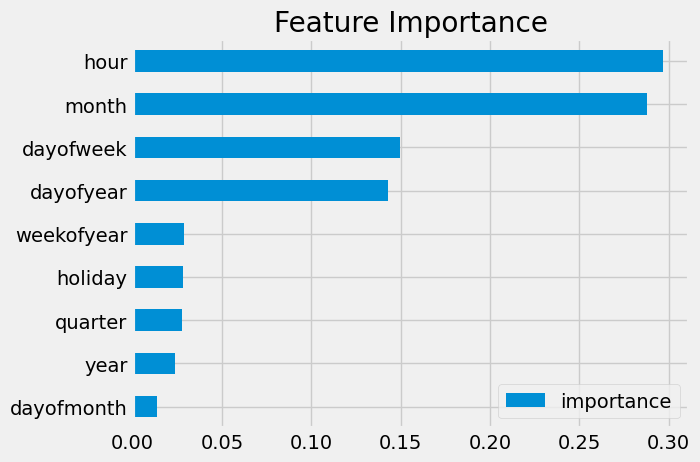

In [24]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Just as we predicted, hour, month, and day of the week are the most important features in predicting the energy consumption. 'Day of the year' we did not foresee, but definitely makes sense as to why it would be a highly contributing feature. Holidays surprisingly barely contribution to our ability to be able to predict consumption. In further analysis we should check to see if they actually may be hindering the models performance. For now we will move on to plotting the models predictions on the actual values.

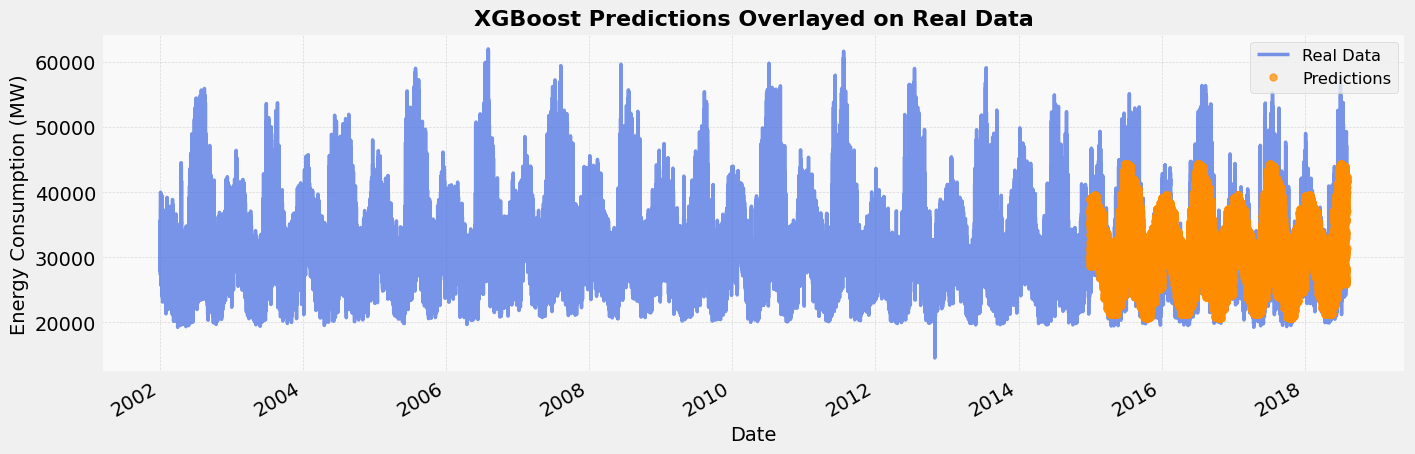

In [25]:
# Pulling out our predictions
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plotting real data
ax = df[['PJME_MW']].plot(figsize=(15, 5), linewidth=2.5, linestyle='-', color='royalblue', alpha=0.7)
# Plotting predictions
df['prediction'].plot(ax=ax, style='o', markersize=5, color='darkorange', alpha=0.7)

plt.legend(['Real Data', 'Predictions'], fontsize='small')
ax.set_title('XGBoost Predictions Overlayed on Real Data', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area


plt.show()

After viewing the model's predictions visually, it appears to do a relatively good job at understanding the seasonality of energy consumption, while not accurately reaching the peaks of consumption. Looking at the model does not tell us a whole let in terms of accuracy, so let's bring out our stats error metrics.

## Error Metrics



**MAE (Mean Absolute Error)**
MAE measures the average magnitude of errors in a set of predictions, without considering their direction. It is calculated as the average of the absolute differences between the predicted and actual values. Unlike RMSE, MAE treats all errors equally, providing a linear measure of error magnitude. It is also in the same units as the observed data, making it intuitive to understand. A smaller MAE value signifies a model with higher accuracy.

**RMSE (Root Mean Square Error)**
RMSE is a widely used metric that measures the square root of the average squared differences between predicted and actual values. This approach gives a higher weight to larger errors, making it particularly sensitive to outliers in the prediction set. Unlike MAE, which treats all errors equally, **RMSE penalizes large errors more severely**, providing a more nuanced view of model performance, especially in datasets where large errors are particularly undesirable. It is expressed in the same units as the observed data, facilitating an intuitive understanding of the error magnitude. A lower RMSE value indicates a model that is more precise, especially in avoiding large errors.

**MAPE (Mean Absolute Percentage Error)**
MAPE expresses the average of the absolute percentage errors between the predicted and actual values, providing a relative measure of prediction errors in percentage terms. It offers a scale-independent metric, making it particularly useful for comparing the accuracy of models across different data scales. However, MAPE can be highly skewed by actual values near zero and is undefined for actual values of zero, limiting its applicability. A lower MAPE value indicates better model performance.

In [26]:
# Function for mape because sklearn does not provide one
def mape(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
mae_score = mean_absolute_error(test['PJME_MW'], test['prediction'])
print(f'Mean Absolute Error Score on Test set: {mae_score:0.2f}')

Mean Absolute Error Score on Test set: 2875.03


In [28]:
rmse_score = sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {rmse_score:0.2f}')

RMSE Score on Test set: 3716.79


In [29]:
mape_score = mape(test['PJME_MW'], test['prediction'])
print(f'Mean Absolute Percentage Error Score on Test set: {mape_score:0.2f}')

Mean Absolute Percentage Error Score on Test set: 9.04


# Using Facebook's Prophet to Forecast Energy Consumption
Facebook's Prophet is a forecasting model tailored for time series data that is typical in business applications. It is designed with simplicity in mind, making it accessible to those with limited statistical modeling experience. Prophet is robust to missing data, shifts in trends, and handles outliers effectively. The model is based on decomposable components that include the trend, seasonality, and holidays, allowing it to adapt to various business scenarios.

The trend component is fitted with the ability to change at specified changepoints, enabling the capture of non-linear growth. Seasonality is modeled using Fourier series, which allows capturing daily, weekly, and yearly patterns (we have each one). Holidays and special events can be incorporated into the model with custom inputs.

Under the hood, Prophet uses Bayesian inference for parameter estimation, offering a full statistical inference framework that provides credible intervals for forecasts. Its transparency in modeling seasonal effects and holidays makes the interpretation of the results straightforward.

Prophet's approach to providing intuitive and actionable forecasts makes it a viable solution for businesses needing to project future trends based on historical data.

In [30]:
# Reset our dataframe and split again
df = df_original.copy()
train, test = split_data(df)

Prophet takes a specific format of data that is not datetime it is 'ds'. We must convert our data back to datetime. 

In [31]:
# Format data for prophet model using ds and y
prophet_train = train.reset_index() \
    .rename(columns={'Datetime':'ds','PJME_MW':'y'})
prophet_train.head()

,ds,y
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0


### A note about prophet before feature creation
Prophet does not take in time features in the same way that xgboost does. Prophet natively models trends, seasonality (daily, weekly, yearly), and holidays, but it does not directly accept arbitrary features like "hour of the day" in the same way a model like XGBoost does. However, it is designed to incorporate holidays, by adding a column 'holiday' in the dataframe. To most fairly compare the models we will add holidays for prophet as well.

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()

# Create a dataframe with holiday, ds columns
df['date'] = df.index.date
df['is_holiday'] = df.date.isin([d.date() for d in cal.holidays()])
holiday_df = df.loc[df['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'
holiday_df = holiday_df.drop(['PJME_MW','date','is_holiday'], axis=1)
holiday_df.head()

,ds,holiday
0,2002-01-01 01:00:00,USFederalHoliday
1,2002-01-01 02:00:00,USFederalHoliday
2,2002-01-01 03:00:00,USFederalHoliday
3,2002-01-01 04:00:00,USFederalHoliday
4,2002-01-01 05:00:00,USFederalHoliday


In [33]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [34]:
# Set up and train model
prophet_model = Prophet(holidays=holiday_df)
prophet_model.fit(prophet_train)

02:16:32 - cmdstanpy - INFO - Chain [1] start processing
02:17:52 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# Predict on training set with model
prophet_fcst = prophet_model.predict(df=test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [36]:
prophet_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,USFederalHoliday,USFederalHoliday_lower,USFederalHoliday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31263.761899,24026.990556,33067.314914,31263.761899,31263.761899,-1839.94345,-1839.94345,-1839.94345,-2486.707263,...,1298.687352,1298.687352,1298.687352,466.976984,466.976984,466.976984,0.0,0.0,0.0,28777.054637
1,2015-01-01 01:00:00,31263.724936,22416.997595,31278.683923,31263.724936,31263.724936,-1839.94345,-1839.94345,-1839.94345,-4509.642364,...,1292.582793,1292.582793,1292.582793,468.275898,468.275898,468.275898,0.0,0.0,0.0,26754.082571
2,2015-01-01 02:00:00,31263.687972,20722.837020,29651.376346,31263.687972,31263.687972,-1839.94345,-1839.94345,-1839.94345,-6012.823936,...,1284.803067,1284.803067,1284.803067,469.612489,469.612489,469.612489,0.0,0.0,0.0,25250.864036
3,2015-01-01 03:00:00,31263.651008,19849.417895,28989.841290,31263.651008,31263.651008,-1839.94345,-1839.94345,-1839.94345,-6883.716634,...,1275.461156,1275.461156,1275.461156,470.986786,470.986786,470.986786,0.0,0.0,0.0,24379.934373
4,2015-01-01 04:00:00,31263.614044,20213.012608,28443.329721,31263.614044,31263.614044,-1839.94345,-1839.94345,-1839.94345,-7024.928447,...,1264.690197,1264.690197,1264.690197,472.398818,472.398818,472.398818,0.0,0.0,0.0,24238.685597


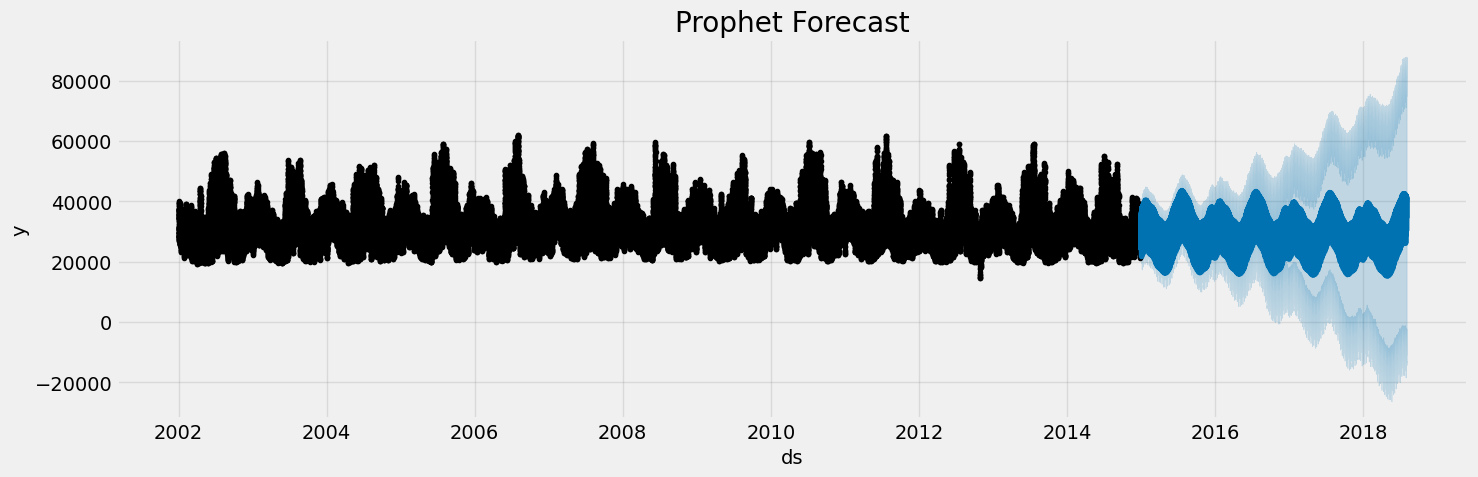

In [37]:
# Plot the forecast
f, ax = plt.subplots(1)
ax.set_title('Prophet Forecast')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)
f.set_figheight(5)
f.set_figwidth(15)
fig = prophet_model.plot(prophet_fcst,ax=ax)
plt.show()

It appears the model understands the general seasonality of our data, while similar to XGBoost can't predict the full range of consumption with confidence. Although, the less confident forecasts do reach the full range of consumption.

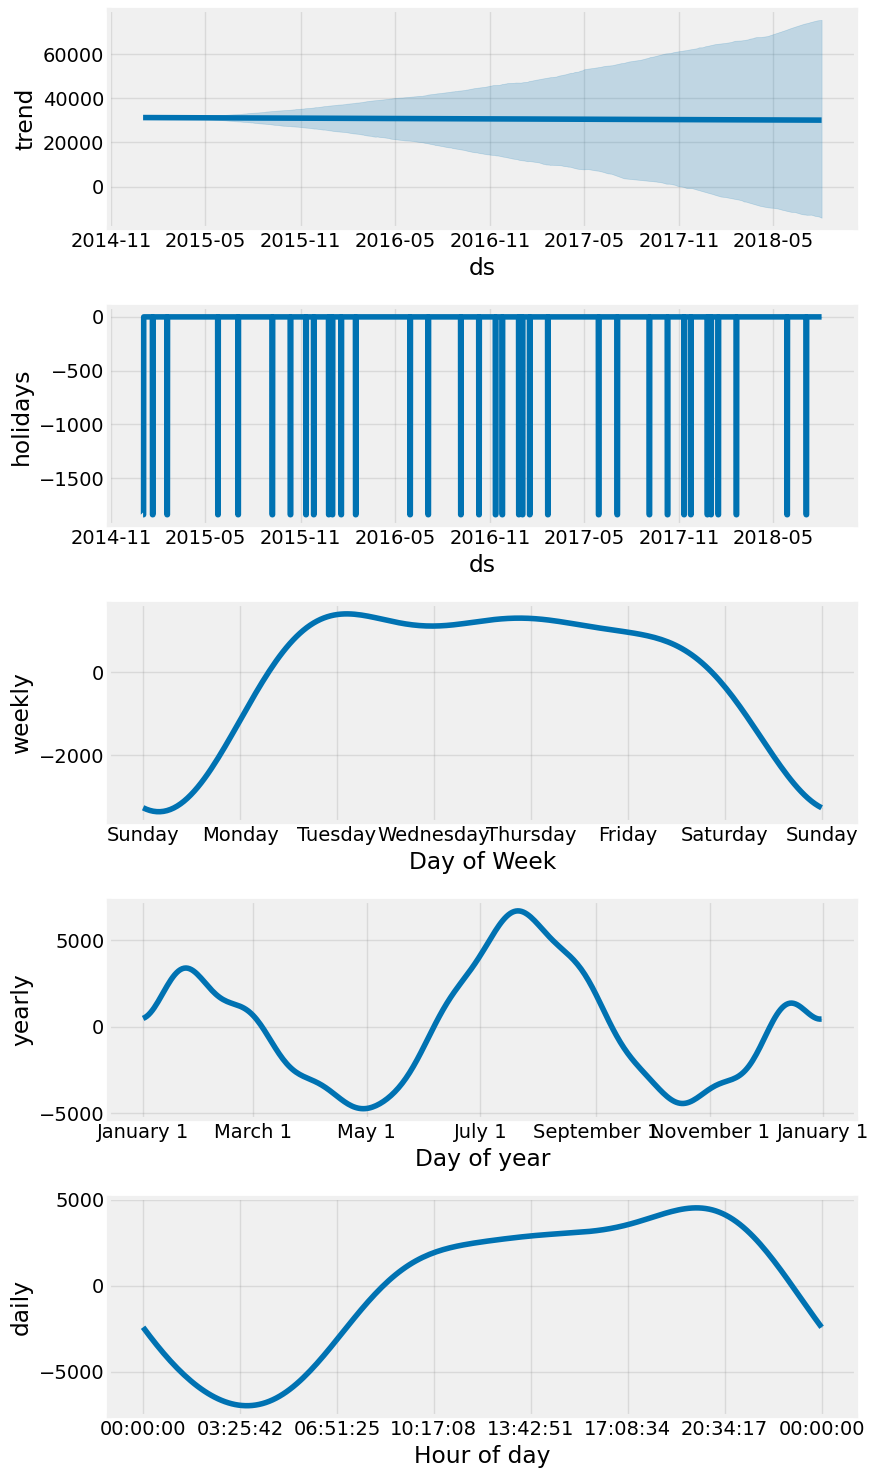

In [38]:
# Plotting the components of the model

warnings.simplefilter("ignore", FutureWarning)
fig = prophet_model.plot_components(prophet_fcst)

These broken down trends the model was able to learn look **very** similar to the visualizations we made plotting the average distributions across different lags. It seems like prophet does a good job of understanding the overall structure of our data.

### Comparing Forecast to Actual Values

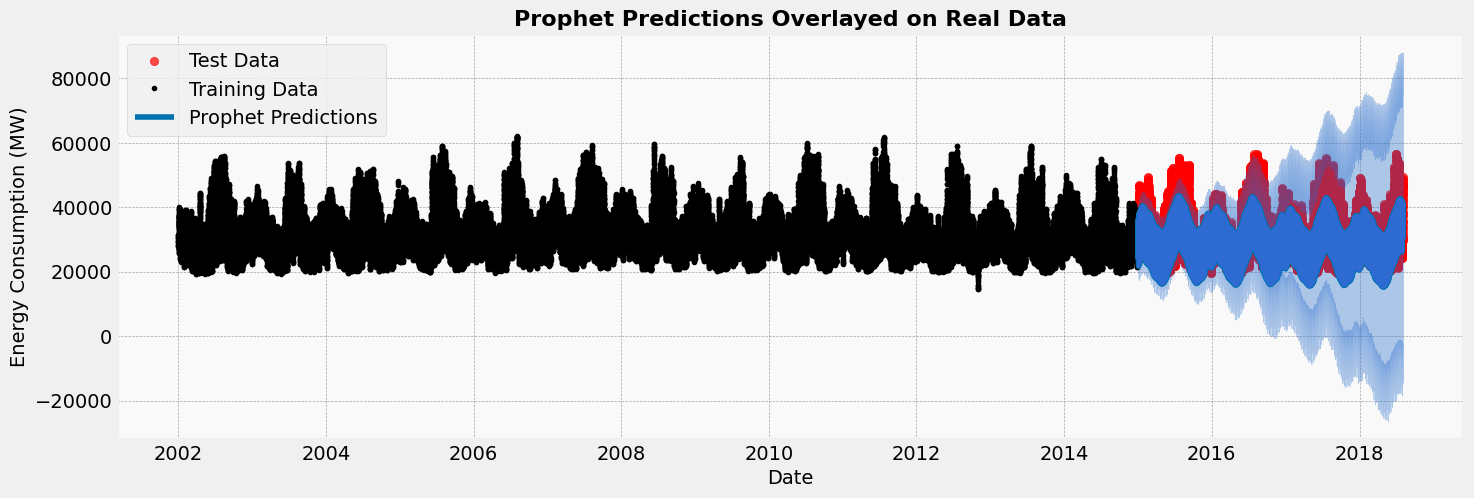

In [39]:
# Set up the plot
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# Plot real test data
ax.scatter(test.index, test['PJME_MW'], color='red', alpha=0.7, label='Real Data')

fig = prophet_model.plot(prophet_fcst, ax=ax, plot_cap=False)

# Plot prophet forecasts
ax.plot(prophet_fcst['ds'], prophet_fcst['yhat'], color='royalblue', linewidth=2.5, alpha=0.7, label='Prophet Predictions')
ax.fill_between(prophet_fcst['ds'], prophet_fcst['yhat_lower'], prophet_fcst['yhat_upper'], color='royalblue', alpha=0.2)

ax.set_title('Prophet Predictions Overlayed on Real Data', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area
plt.legend(['Test Data', 'Training Data', 'Prophet Predictions'], fontsize='medium', loc='upper left')

plt.show()

## Prophet Model Error Metrics

In [40]:
prophet_MAE = mean_absolute_error(test['PJME_MW'], prophet_fcst['yhat'])
print(f'Mean Absolute Error Score on Test set: {prophet_MAE:0.2f}')

Mean Absolute Error Score on Test set: 3102.92


In [41]:
prophet_rmse = sqrt(mean_squared_error(test['PJME_MW'], prophet_fcst['yhat']))
print(f'RMSE Score on Test set: {prophet_rmse:0.2f}')

RMSE Score on Test set: 4116.50


In [42]:
prophet_MAPE = mape(test['PJME_MW'], prophet_fcst['yhat'])
print(f'Mean Absolute Percent Error Score on Test set: {prophet_MAPE:0.2f}')

Mean Absolute Percent Error Score on Test set: 9.62


# Summary of Findings

In this comprehensive analysis of hourly energy consumption forecasting, we evaluated and compared the performance of two advanced forecasting models: XGBoost and Prophet. Our evaluation was based on three critical metrics: Mean Absolute Error (MAE), Root Mean Square Error (RMSE), and Mean Absolute Percentage Error (MAPE). Here are the summarized results:

## XGBoost Performance
- **MAE**: 2875.03
- **RMSE**: 3716.79
- **MAPE**: 9.04%

XGBoost demonstrated a strong performance across all metrics, showcasing its effectiveness in handling time series data. The relatively low MAE and RMSE values indicate that XGBoost was able to make predictions that were close to the actual values, with fewer and less significant errors. The MAPE value underlines its accuracy in percentage terms, making it a robust model for this forecasting task.

## Prophet Performance
- **MAE**: 3102.92
- **RMSE**: 4116.50
- **MAPE**: 9.62%

Prophet, developed by Facebook, also showed a commendable performance but trailed slightly behind XGBoost in this analysis. The higher values of MAE and RMSE suggest that Prophet's predictions were not as close to the actual values as those of XGBoost, indicating more significant errors on average. The slightly higher MAPE further confirms that Prophet, while still effective, was less accurate in percentage terms compared to XGBoost.

## Conclusion

Both XGBoost and Prophet proved to be valuable tools for forecasting hourly energy consumption, each with its strengths. XGBoost outperformed Prophet in terms of MAE, RMSE, and MAPE, indicating it might be the more suitable model for applications where precision is critical. These findings underscore the importance of model selection in time series forecasting and highlight the effectiveness of machine learning techniques in predicting energy consumption patterns.

## Potential Next Steps
In our pursuit to enhance the accuracy of our time series forecasting, incorporating lag values emerges as a promising avenue. By integrating past observations as features, we can capture temporal dependencies more effectively. This, combined with further tuning of model parameters, holds the potential to significantly improve our predictive capabilities. Experimenting with different lag periods and adjusting the model's settings accordingly could lead to a more robust understanding of the underlying patterns in our data, thereby refining our forecasts.